# Projeto 02 – Notebook 2 : Clustering com K-Means

## Introdução

**Unidade Curricular:** Inteligência Artificial  
**Projeto:** Project 02 – Data Mining / Machine Learning  
**Notebook:** Clustering (K-Means)  

Este notebook visa apresentar o trabalho desenvolvido pelo Grupo 3  composto por Tiago Sousa (20735), Rodrigo Castro (23143), Rogério Gomes (27216), Paulo Costa (29851) e Lais Carvalho (51067)  no âmbito do projeto prático da disciplina de Inteligência Artificial.

O presente projeto tem como objetivo aplicar técnicas de Aprendizagem Não Supervisionada, mais concretamente o algoritmo K-Means, para identificar padrões e agrupamentos naturais entre pilotos da Fórmula 1, utilizando dados históricos do Campeonato Mundial entre 1950 e 2020.

### Contexto e objetivo

Neste notebook vamos aplicar técnicas de *clustering* ao conjunto de dados **Formula 1 World Championship (1950–2020)**, disponível no Kaggle.

### Fórmula 1 como domínio de negócio.

A Fórmula 1 é considerada o topo do automobilismo mundial, envolvendo equipas, pilotos e construtores que competem anualmente por títulos de elevado prestígio. O desporto destaca-se pela forte componente tecnológica, grandes investimentos financeiros, estratégias complexas e variabilidade significativa entre épocas, circuitos e desempenhos de pilotos.

A análise de dados desempenha um papel crucial no contexto da F1  desde a gestão de corridas e decisões de equipa até à avaliação de performance dos pilotos. Assim, explorar padrões ocultos nos dados históricos permite entender:

1. diferenças de performance entre pilotos ao longo das décadas;

2. perfis típicos de pilotos (ex.: campeões dominantes, pilotos consistentes, estreantes, etc.);

3. relações entre métricas como corridas disputadas, pontos acumulados, vitórias ou pódios.

O objetivo deste projeto consiste em aplicar técnicas de Aprendizagem Não Supervisionada, utilizando o algoritmo K-Means, para identificar grupos de pilotos com padrões de desempenho semelhantes ao longo da carreira na Fórmula 1.

Para isso, os pilotos serão agrupados com base em várias métricas de performance ao longo das épocas, nomeadamente:

1. número total de corridas disputadas;

2. número de vitórias;

3. número de pódios;

4. total de pontos acumulados;

5. número de épocas em que competiram.


## 1. Dataset

### 1.1 Fonte dos dados

Os dados utilizados neste notebook pertencem ao dataset:

- **Formula 1 World Championship (1950 - 2020)** – autor: *Rohan Rao* – disponível em Kaggle.  
  Link: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020

O dataset contém múltiplos ficheiros CSV com informação sobre:

- Corridas, circuitos e temporadas;
- Pilotos e construtores;
- Resultados de corridas, classificações, tempos de volta, *pit stops*, etc. 

Neste notebook vamos utilizar principalmente:

- `drivers.csv` – informação base dos pilotos;
- `results.csv` – resultados de cada piloto em cada corrida;
- `driver_standings.csv` – classificação dos pilotos ao longo da época.
-  `races.csv` – lista de todas as corridas, com ano, localização, circuito e outras informações essenciais

O ficheiro races.csv é especialmente importante porque nos permite ligar os resultados ao ano da corrida, algo fundamental para calcular métricas como o número de épocas ativas por piloto.

### 1.2 Metadados resumidos

| Ficheiro | Nº linhas (aprox.) | Descrição |
|---------|--------------------|-----------|
| `drivers.csv` | ~850 | Identificação e dados demográficos dos pilotos |
| `results.csv` | ~250 000 | Resultado de cada piloto em cada corrida (posição final, pontos, etc.) |
| `driver_standings.csv` | ~50 000 | Classificação acumulada dos pilotos ao longo das épocas |
| `races.csv` | ~1000 | Lista de todas as corridas: inclui ano, nome da corrida, circuito, país, data, e IDs usados para relacionar com results e driver_standings |
> **Nota:** Os valores exatos podem variar conforme a versão do dataset. 


In [2]:
%pip install pandas numpy matplotlib seaborn scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 54.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 64.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [seaborn]m4/5 [seaborn]earn]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# 2. Importação de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configurações gráficas
plt.style.use('seaborn-v0_8')
sns.set(font_scale=1.1)



In [4]:
# Carregar os datasets essenciais
drivers = pd.read_csv("drivers.csv")
results = pd.read_csv("results.csv")
races = pd.read_csv("races.csv")
driver_standings = pd.read_csv("driver_standings.csv")


drivers.head()


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


## 2. Análise Exploratória dos Dados (EDA)

Nesta secção vamos:
- Explorar a estrutura dos ficheiros relevantes;
- Verificar valores em falta;
- Construir *features* agregadas de desempenho por piloto (vitórias, pódios, pontos, nº de corridas, etc.), que serão usadas pelo K-Means.


In [5]:
# Visão geral das tabelas principais
print("drivers:")
display(drivers.info())

print("\nresults:")
display(results.info())

print("\nraces:")
display(races.info())

print("\ndriver_standings:")
display(driver_standings.info())

# Contagem de valores em falta em cada dataset
print("\nMissing values (drivers):")
display(drivers.isna().sum())

print("\nMissing values (results):")
display(results.isna().sum())

print("\nMissing values (races):")
display(races.isna().sum())

print("\nMissing values (driver_standings):")
display(driver_standings.isna().sum())



drivers:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   driverId     861 non-null    int64 
 1   driverRef    861 non-null    object
 2   number       861 non-null    object
 3   code         861 non-null    object
 4   forename     861 non-null    object
 5   surname      861 non-null    object
 6   dob          861 non-null    object
 7   nationality  861 non-null    object
 8   url          861 non-null    object
dtypes: int64(1), object(8)
memory usage: 60.7+ KB


None


results:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         26759 non-null  int64  
 1   raceId           26759 non-null  int64  
 2   driverId         26759 non-null  int64  
 3   constructorId    26759 non-null  int64  
 4   number           26759 non-null  object 
 5   grid             26759 non-null  int64  
 6   position         26759 non-null  object 
 7   positionText     26759 non-null  object 
 8   positionOrder    26759 non-null  int64  
 9   points           26759 non-null  float64
 10  laps             26759 non-null  int64  
 11  time             26759 non-null  object 
 12  milliseconds     26759 non-null  object 
 13  fastestLap       26759 non-null  object 
 14  rank             26759 non-null  object 
 15  fastestLapTime   26759 non-null  object 
 16  fastestLapSpeed  26759 non-null  object 
 17  st

None


races:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   raceId       1125 non-null   int64 
 1   year         1125 non-null   int64 
 2   round        1125 non-null   int64 
 3   circuitId    1125 non-null   int64 
 4   name         1125 non-null   object
 5   date         1125 non-null   object
 6   time         1125 non-null   object
 7   url          1125 non-null   object
 8   fp1_date     1125 non-null   object
 9   fp1_time     1125 non-null   object
 10  fp2_date     1125 non-null   object
 11  fp2_time     1125 non-null   object
 12  fp3_date     1125 non-null   object
 13  fp3_time     1125 non-null   object
 14  quali_date   1125 non-null   object
 15  quali_time   1125 non-null   object
 16  sprint_date  1125 non-null   object
 17  sprint_time  1125 non-null   object
dtypes: int64(4), object(14)
memory usage: 158.3+ KB


None


driver_standings:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34863 entries, 0 to 34862
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   driverStandingsId  34863 non-null  int64  
 1   raceId             34863 non-null  int64  
 2   driverId           34863 non-null  int64  
 3   points             34863 non-null  float64
 4   position           34863 non-null  int64  
 5   positionText       34863 non-null  object 
 6   wins               34863 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 1.9+ MB


None


Missing values (drivers):


driverId       0
driverRef      0
number         0
code           0
forename       0
surname        0
dob            0
nationality    0
url            0
dtype: int64


Missing values (results):


resultId           0
raceId             0
driverId           0
constructorId      0
number             0
grid               0
position           0
positionText       0
positionOrder      0
points             0
laps               0
time               0
milliseconds       0
fastestLap         0
rank               0
fastestLapTime     0
fastestLapSpeed    0
statusId           0
dtype: int64


Missing values (races):


raceId         0
year           0
round          0
circuitId      0
name           0
date           0
time           0
url            0
fp1_date       0
fp1_time       0
fp2_date       0
fp2_time       0
fp3_date       0
fp3_time       0
quali_date     0
quali_time     0
sprint_date    0
sprint_time    0
dtype: int64


Missing values (driver_standings):


driverStandingsId    0
raceId               0
driverId             0
points               0
position             0
positionText         0
wins                 0
dtype: int64

### 2.1 Construção do dataset para clustering

O objetivo é caracterizar cada piloto ao nível de desempenho ao longo da carreira.  
Exemplos de atributos:

- Nº total de corridas disputadas;
- Nº total de vitórias;
- Nº total de pódios (top 3);
- Pontos totais;
- Nº de temporadas (anos) em que o piloto participou.

A seguir vamos criar uma *tabela agregada por piloto* com estas *features* numéricas.


In [6]:
# Garantir que a coluna 'position' é numérica (e ignorar valores não numéricos como 'R', 'DNF', '\N', etc.)
results["position"] = pd.to_numeric(results["position"], errors="coerce")

# 1) Estatísticas base por piloto a partir da tabela results
driver_stats = (
    results
    .groupby("driverId")
    .agg(
        total_races=("raceId", "nunique"),           # nº de corridas diferentes
        wins=("position", lambda x: (x == 1).sum()), # vitórias
        podiums=("position", lambda x: (x <= 3).sum()),
        total_points=("points", "sum")               # soma de pontos em todas as corridas
    )
    .reset_index()
)

# 2) Número de épocas (anos) em que o piloto aparece na classificação de pilotos
#    -> é preciso juntar driver_standings com races para obter o 'year'
driver_standings_with_year = (
    driver_standings
    .merge(races[["raceId", "year"]], on="raceId", how="left")
)

seasons_per_driver = (
    driver_standings_with_year
    .groupby("driverId")["year"]
    .nunique()
    .rename("seasons")
    .reset_index()
)

# Juntar nº de épocas ao driver_stats
driver_stats = driver_stats.merge(seasons_per_driver, on="driverId", how="left")

# 3) Adicionar informação descritiva do piloto
driver_stats = driver_stats.merge(
    drivers[["driverId", "forename", "surname", "nationality"]],
    on="driverId",
    how="left"
)

# Opcional: ordenar por pontos totais
driver_stats = driver_stats.sort_values("total_points", ascending=False)

driver_stats.head()


,driverId,total_races,wins,podiums,total_points,seasons,forename,surname,nationality
0,1,356,105,202,4820.5,18.0,Lewis,Hamilton,British
19,20,300,53,122,3098.0,16.0,Sebastian,Vettel,German
828,830,209,63,112,2912.5,10.0,Max,Verstappen,Dutch
3,4,404,32,106,2329.0,21.0,Fernando,Alonso,Spanish
7,8,352,21,103,1873.0,19.0,Kimi,Räikkönen,Finnish


In [7]:
# Remover pilotos com muito poucas corridas (por ex. < 10) para evitar ruído
min_races = 10
driver_stats_filtered = driver_stats[driver_stats['total_races'] >= min_races].copy()

print("Número de pilotos considerados:", len(driver_stats_filtered))

numeric_features = ['total_races', 'wins', 'podiums', 'total_points', 'seasons']
driver_stats_filtered[numeric_features].describe()


Número de pilotos considerados: 374


,total_races,wins,podiums,total_points,seasons
count,374.000000,374.000000,374.000000,374.000000,373.000000
mean,67.403743,2.989305,8.962567,141.272861,5.970509
std,70.271783,10.057203,21.870167,434.122877,4.138293
min,10.000000,0.000000,0.000000,0.000000,1.000000
25%,17.000000,0.000000,0.000000,1.000000,3.000000
50%,38.000000,0.000000,0.500000,11.000000,5.000000
75%,95.000000,1.000000,7.000000,77.480000,8.000000
max,404.000000,105.000000,202.000000,4820.500000,21.000000


## 3. Preparação dos dados para K-Means

O algoritmo K-Means é sensível à escala dos atributos.  
Vamos portanto:

1. Selecionar apenas as *features* numéricas de interesse;
2. Normalizar/standardizar os dados com `StandardScaler`.
3. Remover pilotos sem corridas para evitar clusters inúteis


In [ ]:
from sklearn.preprocessing import StandardScaler

# Features para o clustering
features = ["total_races", "wins", "podiums", "total_points", "seasons"]

# Criar dataframe com apenas essas colunas
X = driver_stats[features].copy()

# 1) Tratar valores NaN
X = X.fillna(0)

# 2) Remover pilotos sem corridas (evita clusters inúteis)
mask_valid = X["total_races"] > 0
X = X[mask_valid]

# Guardar stats filtradas para análise posterior
driver_stats_cluster = driver_stats.loc[mask_valid].reset_index(drop=True)

# 3) Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]


array([[ 5.78058662, 15.28858804, 13.15517416, 16.17986545,  4.01695741],
       [ 4.78462894,  7.62143229,  7.84144842, 10.32329465,  3.45485757],
       [ 3.16619772,  9.09588532,  7.1772327 ,  9.69258702,  1.76855804],
       [ 6.63426464,  4.52508093,  6.77870327,  7.70866304,  4.86010717],
       [ 5.70944679,  2.9031826 ,  6.57943855,  6.15824429,  4.29800733]])

## 4. Escolha do número de clusters (k)

Para selecionar um valor adequado de **k** vamos usar:

- **Método do cotovelo (*elbow method*)**, analisando a inércia (SSE);
- **Coeficiente de *silhouette*** como métrica complementar de qualidade.

Os valores de k a testar serão, por exemplo, de 2 a 10.


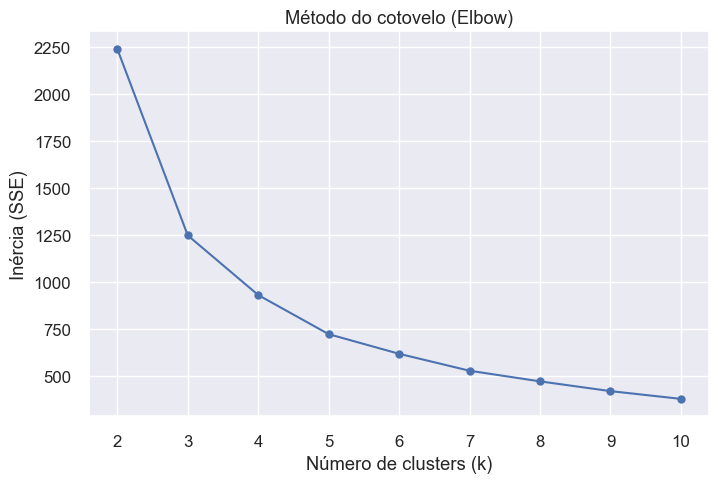

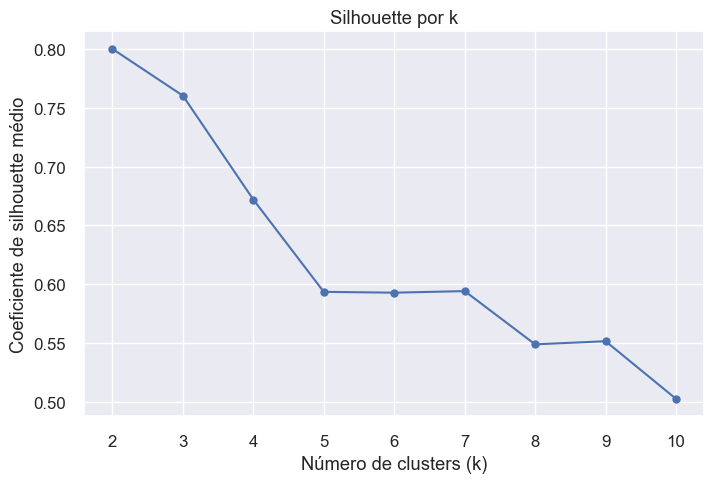

,k,inertia,silhouette
0,2,2237.999148,0.799902
1,3,1247.186993,0.760173
2,4,930.267840,0.671974
3,5,722.388874,0.593639
4,6,618.030813,0.592948
5,7,528.048922,0.594275
6,8,471.584360,0.549077
7,9,419.691334,0.551739
8,10,378.485972,0.502779


In [ ]:
inertias = []
sil_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Gráfico do método do cotovelo
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(k_values, inertias, marker='o')
ax1.set_xlabel('Número de clusters (k)')
ax1.set_ylabel('Inércia (SSE)')
ax1.set_title('Método do cotovelo (Elbow)')

plt.show()

# Gráfico do silhouette
fig, ax2 = plt.subplots(figsize=(8,5))
ax2.plot(k_values, sil_scores, marker='o')
ax2.set_xlabel('Número de clusters (k)')
ax2.set_ylabel('Coeficiente de silhouette médio')
ax2.set_title('Silhouette por k')

plt.show()

pd.DataFrame({'k': list(k_values),
              'inertia': inertias,
              'silhouette': sil_scores})


## 5. Aplicação do K-Means

Com base na análise anterior (gráficos do *elbow* e do *silhouette*), selecionar um valor de **k** apropriado (por exemplo, 3, 4 ou 5) e treinar o modelo final.

> **Nota:** o valor de k deve ser justificado com base nos gráficos e na interpretação de negócio (tipos de pilotos que se pretende distinguir).


In [ ]:
# Definir o número de clusters selecionado
k_selected = 4

kmeans_final = KMeans(n_clusters=k_selected, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Adicionar os clusters ao DataFrame correto (aquele filtrado!)
driver_stats_cluster['cluster'] = cluster_labels

# Estatísticas médias por cluster
driver_stats_cluster.groupby('cluster')[[
    "total_races", "wins", "podiums", "total_points", "seasons"
]].mean().round(2)


,total_races,wins,podiums,total_points,seasons
cluster,,,,,
0,9.87,0.03,0.21,3.19,2.34
1,315.40,68.80,139.40,2945.20,16.80
2,97.72,2.05,8.72,112.87,8.70
3,199.57,17.79,50.89,773.93,13.00


## 6. Análise das características de cada cluster

De acordo com as orientações do projeto, é importante analisar:

- **Número de elementos em cada cluster**;
- **Média, desvio padrão, máximo e mínimo** dos atributos numéricos;
- **Distribuição de atributos categóricos**, por exemplo nacionalidade.

Esta análise permite interpretar e dar nomes aos grupos, como por exemplo:  
*Pilotos lendários*, *pilotos consistentes*, *pilotos de meio da grelha*, *pilotos com carreira curta*, etc. 


In [ ]:
# 1) Número de pilotos por cluster
driver_stats_cluster['cluster'].value_counts().sort_index().to_frame(name="n_pilotos")



,n_pilotos
cluster,
0,699
1,5
2,129
3,28


In [ ]:
# 2) Estatísticas médias por cluster
features = ["total_races", "wins", "podiums", "total_points", "seasons"]

cluster_summary = (
    driver_stats_cluster
    .groupby('cluster')[features]
    .agg(['mean', 'std', 'min', 'max'])
    .round(2)
)

cluster_summary


total_races                    wins                 podiums         \
               mean    std  min  max   mean    std min  max    mean    std   
cluster                                                                      
0              9.87  13.24    1   68   0.03   0.20   0    2    0.21   0.94   
1            315.40  72.65  209  404  68.80  29.33  32  105  139.40  39.78   
2             97.72  51.99    9  256   2.05   3.25   0   16    8.72   9.46   
3            199.57  73.55   51  352  17.79  10.87   4   51   50.89  19.85   

                  total_points                          seasons              \
         min  max         mean      std     min     max    mean   std   min   
cluster                                                                       
0          0   13         3.19    15.73     0.0   347.0    2.34  1.59   1.0   
1        106  202      2945.20  1206.55  1566.0  4820.5   16.80  4.21  10.0   
2          0   33       112.87   137.88     0.0   950.0    8.70  2.66   4.0   
3         27  106       773.93   528.54   261.0  1873.0   13.00  3.40   7.0   

               
          max  
cluster        
0         8.0  
1        21.0  
2        16.0  
3        19.0

In [ ]:
# 3) Ver alguns pilotos de cada cluster
cols_to_show = [
    "forename", "surname", "nationality",
    "total_races", "wins", "podiums", "total_points", "seasons", "cluster"
]

driver_stats_cluster[cols_to_show].sort_values('cluster').head(30)


,forename,surname,nationality,total_races,wins,podiums,total_points,seasons,cluster
860,Marcel,Balsa,French,1,0,0,0.0,1.0,0
699,Carl,Scarborough,American,2,0,0,0.0,2.0,0
700,Giorgio,Francia,Italian,2,0,0,0.0,2.0,0
701,Bob,Scott,American,3,0,0,0.0,3.0,0
702,Arthur,Legat,Belgian,2,0,0,0.0,2.0,0
703,Dave,Kennedy,Irish,7,0,0,0.0,1.0,0
704,Tony,Crook,British,2,0,0,0.0,2.0,0
705,Jimmy,Stewart,British,1,0,0,0.0,1.0,0
706,Ian,Stewart,British,1,0,0,0.0,1.0,0
707,Duncan,Hamilton,British,5,0,0,0.0,3.0,0


In [ ]:
# Distribuição de nacionalidades por cluster (top 10)
nationality_cluster = (
    driver_stats_cluster
    .groupby(['cluster', 'nationality'])['driverId']
    .count()
    .rename('count')
    .reset_index()
)


top_nat = (nationality_cluster
           .sort_values('count', ascending=False)
           .groupby('cluster')
           .head(10))

top_nat


,cluster,nationality,count
0,0,American,145
9,0,British,140
25,0,Italian,75
19,0,French,54
20,0,German,37
60,2,Italian,23
8,0,Brazilian,23
2,0,Argentine,21
35,0,South African,21
38,0,Swiss,20


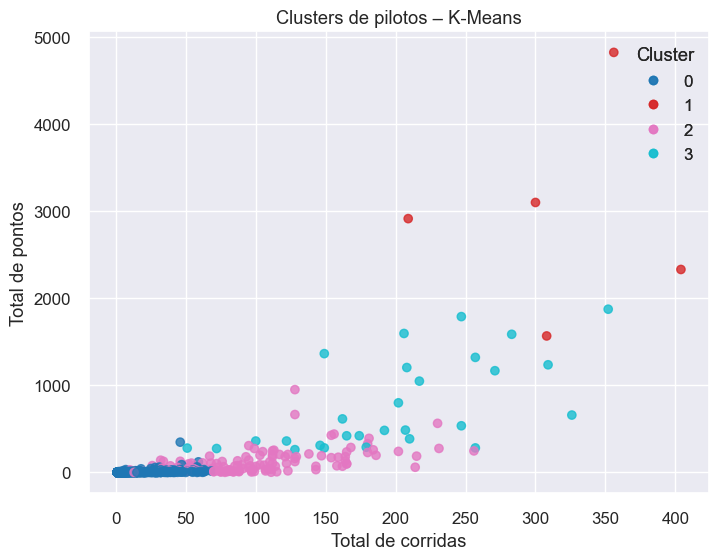

In [ ]:
# Visualização 2D dos clusters com duas das features (ex.: total_points vs total_races)

fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(
    driver_stats_cluster['total_races'],
    driver_stats_cluster['total_points'],
    c=driver_stats_cluster['cluster'],
    cmap='tab10',
    alpha=0.8
)

ax.set_xlabel('Total de corridas')
ax.set_ylabel('Total de pontos')
ax.set_title('Clusters de pilotos – K-Means')

legend1 = ax.legend(*scatter.legend_elements(), title='Cluster')
ax.add_artist(legend1)

plt.show()


## 7. Conclusão

Nesta secção devem ser resumidos:

- O **objetivo de negócio** e se foi atingido (identificação de grupos de pilotos com padrões de desempenho semelhantes);
- As principais características de cada *cluster* (por exemplo, pilotos com muitas vitórias vs. pilotos com poucas corridas);
- Interpretações possíveis para uma organização que queira utilizar estes resultados (ex.: análises históricas, marketing, conteúdos, etc.);
- Limitações do estudo (ex.: apenas algumas *features* consideradas, ausência de fatores contextuais como qualidade do carro, regras por época, etc.);
- Trabalho futuro (ex.: testar outros algoritmos de clustering como DBSCAN ou Birch, incorporar mais variáveis, fazer *clustering* por época em vez de carreira, etc.).

> **Tarefa para o grupo:** completar esta conclusão com texto próprio, com base nos resultados concretos obtidos.
